## Flow around NACA 0012 airfoil

In [1]:
# Import modules
import numpy as np
import ngsolve as ngs
import netgen.occ as occ
from ngsolve.webgui import Draw
from dream.mesh import get_2d_naca_occ_profile
from dream.compressible import CompressibleFlowSolver, FarField, InviscidWall, Initial
from dream.io import PointSensor, BoundarySensor

In [2]:
# Create Geometry
AoA = 0
LE = (-0.5, 0)

air = occ.WorkPlane().Circle(0, 0, 2).Face()
for edge in air.edges:
    edge.name = "farfield"
airfoil = get_2d_naca_occ_profile('0012', AoA, LE=LE, n=200)
for edge in airfoil.edges:
    edge.name = "airfoil"
    edge.maxh = 0.025

air -= airfoil
air.faces[0].name = "air"

geo = occ.OCCGeometry(air, dim=2)
mesh = ngs.Mesh(geo.GenerateMesh(maxh=0.5, grading=0.2))
mesh.Curve(3)
Draw(mesh)

print(mesh.GetBoundaries())
print(mesh.GetMaterials())

WebGuiDocuWidget(value={'render_data': 'render_data_0.json', 'preview': 'preview_0.png'})

('farfield', 'airfoil')
('air',)


In [3]:
cfg = CompressibleFlowSolver(mesh)
list(cfg.CONFIG)

['time',
 'linear_solver',
 'nonlinear_solver',
 'optimizations',
 'io',
 'info',
 'fem',
 'mach_number',
 'reynolds_number',
 'prandtl_number',
 'equation_of_state',
 'dynamic_viscosity',
 'scaling',
 'riemann_solver']

In [4]:
# Set configuration
cfg.mach_number = 0.1
cfg.equation_of_state = "ideal"
cfg.dynamic_viscosity = "inviscid"
cfg.scaling = "aerodynamic"
cfg.riemann_solver = "lax_friedrich"
cfg.optimizations.static_condensation = True

cfg.time = "pseudo_time_stepping"

cfg.fem = "conservative"
cfg.fem.order = 3
cfg.fem.method = "hdg"
cfg.fem.scheme = "implicit_euler"

# Curve mesh
mesh.Curve(cfg.fem.order)

# Get farfield state
Uinf = cfg.get_farfield_fields(direction=(1, 0))

# Set boundary conditions
cfg.bcs['farfield'] = FarField(fields=Uinf)
cfg.bcs['airfoil'] = InviscidWall()
cfg.dcs['air'] = Initial(fields=Uinf)

In [5]:
ngs.SetNumThreads(4)

cfg.time.timer.step = 0.001
cfg.time.max_time_step = 10
cfg.time.increment_at = 10
cfg.time.increment_factor = 10

cfg.nonlinear_solver.max_iterations = 300
cfg.nonlinear_solver.convergence_criterion = 1e-12

cfg.initialize()
with ngs.TaskManager():
    cfg.solve()

Uh = cfg.get_solution_fields()
cfg.io.draw({"M": cfg.get_local_mach_number(Uh)})


WebGuiDocuWidget(value={'render_data': 'render_data_1.json', 'preview': 'preview_1.png'})

In [6]:
cp = PointSensor.from_boundary({'c_p': cfg.pressure_coefficient(Uh, Uinf)}, mesh, 'airfoil')
cp_ = cp.measure_as_dict()


C = BoundarySensor({"c_l": cfg.lift_coefficient(Uh, None, Uinf, (0, 1)), "c_d": cfg.drag_coefficient(Uh, None, Uinf, (1, 0))}, mesh, 'airfoil')
C_ = C.measure_as_dict()
C_

{'airfoil': array([-0.02551023, -0.00028041])}

Text(0.5, 1.0, 'Pressure coefficient over chord length')

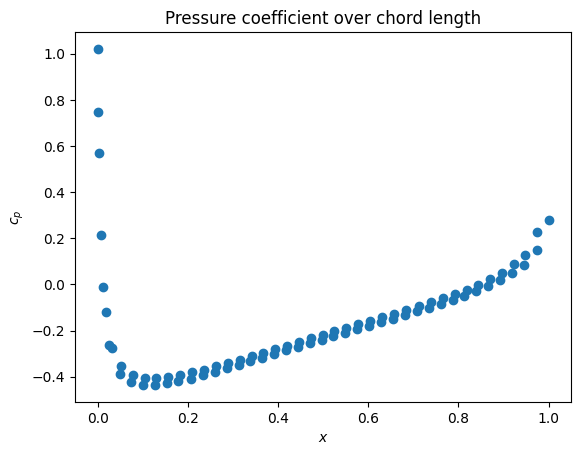

In [7]:
import matplotlib.pyplot as plt
x_ = np.array(list(cp_.keys()))
x_ = np.cos(np.deg2rad(AoA)) * (x_[:, 0] - LE[0]) - np.sin(np.deg2rad(AoA)) * (x_[:, 1] - LE[1])
values = np.array(list(cp_.values())).flatten()

fig, ax = plt.subplots()
ax.plot(x_, values, 'o')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$c_p$")
ax.set_title("Pressure coefficient over chord length")